In [1]:
import requests
import os

#Function to list files in a GitHub repository directory
def list_files_in_github_repo(repo_url, branch, folder_path):
    api_url = f"https://api.github.com/repos/{repo_url.split('/')[-2]}/{repo_url.split('/')[-1]}/contents/{folder_path}?ref={branch}"
    response = requests.get(api_url)
    response.raise_for_status()
    return response.json()

#Function to download a file from GitHub
def download_file_from_github(download_url, local_path):
    response = requests.get(download_url)
    response.raise_for_status()
    with open(local_path, 'wb') as file:
        file.write(response.content)

#Function to download all PDFs from a GitHub directory
def download_pdfs_from_github(repo_url, branch, folder_path, target_path):
    #List all files and directories in the specified GitHub folder
    items = list_files_in_github_repo(repo_url, branch, folder_path)

    #Ensure the target directory exists
    if not os.path.exists(target_path):
        os.makedirs(target_path)

    for item in items:
        item_path = os.path.join(folder_path, item['name'])
        local_item_path = os.path.join(target_path, item['name'])

        if item['type'] == 'dir':
            #Recursively download PDFs from subdirectories
            download_pdfs_from_github(repo_url, branch, item_path, local_item_path)
        elif item['name'].endswith('.pdf'):
            #Download PDF file
            print(f"Downloading {item['name']}...")
            if not os.path.exists(target_path):
                os.makedirs(target_path)
            download_file_from_github(item['download_url'], local_item_path)

repo_url = 'https://github.com/geeklicantropo/MESTRADO_PUBLICO'
branch = 'main'
folder_path = 'BUSCA_E_MINERACAO_DE_TEXTO/TAREFAS/Trabalho_Final/papers'  #Path to the folder in the repository
target_path = '/content/papers'  #Local path in Google Colab or local environment

download_pdfs_from_github(repo_url, branch, folder_path, target_path)


In [3]:
!pip install fitz
!pip install pip install PyMuPDF==1.19.0
!python -m spacy download pt_core_news_sm
!pip install nltk


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 14.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.6/95.6 kB 12.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 421.5/421.5 kB 31.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 531.9/531.9 kB 28.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 137.9/137.9 kB 15.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.1/5.1 MB 26.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 528.1/528.1 kB 24.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.7/41.7 kB 4.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.8/8.8 MB 20.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.0/13.0 MB 24.9 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('pt_core_news_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may nee

In [4]:
#Importando as bibliotecas
import spacy
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from collections import defaultdict, Counter
import numpy as np
from tqdm import tqdm
import os
import glob
import re
import unicodedata
import fitz  #para leitura de PDFs

#Inicializa o modelo de língua portuguesa do SpaCy para processamento de texto
nlp = spacy.load("pt_core_news_sm")

In [34]:
#Classe responsável por processar os testos e gerar os gráficos
class TextProcessor:
    def __init__(self, additional_words):
        self.stop_words = self.setup_custom_stopwords(additional_words)

    def setup_custom_stopwords(self, additional_words):
        spacy_stopwords = nlp.Defaults.stop_words
        spacy_stopwords.update(additional_words)
        return spacy_stopwords

    def clean_text(self, text):
        text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8')
        text = re.sub(r'[^\w\s]', '', text)
        text = re.sub(r'\d+', '', text)
        text = re.sub(r'\s+', ' ', text)
        return text.strip()

    def consolidate_words_by_root(self, text):
        doc = nlp(text)
        root_dict = defaultdict(list)
        for token in doc:
            if token.text.lower() not in self.stop_words and len(token.text) >= 3:
                root_dict[token.lemma_].append(token.text.lower())
        consolidated_text = []
        for lemma, words in root_dict.items():
            most_common = Counter(words).most_common(1)[0][0]
            consolidated_text.append(most_common)
        return ' '.join(consolidated_text)

    def remove_stopwords(self, text):
        words = text.split()
        filtered_words = [word for word in words if word.lower() not in self.stop_words]
        return ' '.join(filtered_words)

    def extract_text_from_pdf(self, pdf_file):
        text = ''
        with fitz.open(pdf_file) as doc:
            for page in doc:
                text += page.get_text()
        return text

    def process_pdfs(self, base_path):
        doc_contents = []
        years = sorted([d for d in os.listdir(base_path) if os.path.isdir(os.path.join(base_path, d))])
        for year in years:
            year_path = os.path.join(base_path, year)
            pdf_files = glob.glob(f"{year_path}/*.pdf")
            for pdf_file in tqdm(pdf_files, desc=f"Processing year {year}"):
                text = self.extract_text_from_pdf(pdf_file)
                cleaned_text = self.clean_text(text)
                filtered_text = self.remove_stopwords(cleaned_text)
                consolidated_text = self.consolidate_words_by_root(filtered_text)
                doc_contents.append({'text': consolidated_text, 'year': year})
        return pd.DataFrame(doc_contents)

    def compute_tfidf(self, docs):
        vectorizer = TfidfVectorizer(min_df=0.01, max_df=0.95)
        tfidf_matrix = vectorizer.fit_transform(docs)
        return tfidf_matrix, vectorizer.get_feature_names_out()

    def plot_wordcloud(self, text, title="Most Important Words in All Articles", max_words=50):
        wordcloud = WordCloud(width=800, height=400, background_color='white', max_words=max_words).generate(text)
        plt.figure(figsize=(10, 5))
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis("off")
        plt.title(title)
        plt.show()

    def plot_topic_evolution(self, docs_df, tfidf_features, tfidf_matrix, num_words=10):
        tfidf_features_list = tfidf_features.tolist()
        tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=tfidf_features_list)
        tfidf_df['year'] = docs_df['year'].values
        yearly_data = tfidf_df.groupby('year').mean()
        top_words = yearly_data.mean().sort_values(ascending=False).head(num_words).index
        plt.figure(figsize=(12, 8))
        for word in top_words:
            plt.plot(yearly_data.index, yearly_data[word], marker='o', label=word)
        plt.title(f'Evolution of Top {num_words} Words Over Years')
        plt.xlabel('Year')
        plt.ylabel('Average TF-IDF Score')
        plt.legend(title='Top Words')
        plt.show()

    def plot_wordclouds_by_year(self, docs_df):
        years = docs_df['year'].unique()
        num_years = len(years)
        cols = 4
        rows = (num_years + 1) // cols

        fig, axes = plt.subplots(rows, cols, figsize=(15, 5 * rows))
        axes = axes.flatten()

        for i, year in enumerate(years):
            year_text = ' '.join(docs_df[docs_df['year'] == year]['text'])
            wordcloud = WordCloud(width=800, height=400, background_color='white', max_words=50).generate(year_text)
            axes[i].imshow(wordcloud, interpolation='bilinear')
            axes[i].axis("off")
            axes[i].set_title(f'Word Cloud for Year {year}')

        for j in range(i + 1, len(axes)):
            fig.delaxes(axes[j])

        plt.tight_layout()
        plt.show()

    def plot_tfidf_by_year(self, docs_df, num_words=10):
        years = docs_df['year'].unique()
        num_years = len(years)
        cols = 2
        rows = (num_years + 1) // cols

        fig, axes = plt.subplots(rows, cols, figsize=(15, 5 * rows))
        axes = axes.flatten()

        for i, year in enumerate(years):
            year_docs = docs_df[docs_df['year'] == year]['text']
            tfidf_matrix, tfidf_features = self.compute_tfidf(year_docs)
            tfidf_features_list = tfidf_features.tolist()
            tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=tfidf_features_list)
            top_words = tfidf_df.mean().sort_values(ascending=False).head(num_words).index

            for word in top_words:
                axes[i].plot(tfidf_df.index, tfidf_df[word], marker='o', label=word)

            if len(tfidf_df) > 20:
                segment_size = len(tfidf_df) // 20
                axes[i].set_xticks(range(0, len(tfidf_df), segment_size))

            axes[i].set_title(f'Top {num_words} Words for Year {year}')
            axes[i].set_xlabel('Document Index')
            axes[i].set_ylabel('TF-IDF Score')
            axes[i].legend(title='Top Words', loc='upper right')

        for j in range(i + 1, len(axes)):
            fig.delaxes(axes[j])

        plt.tight_layout()
        plt.show()

    def compute_lda(self, docs, num_topics=5):
        vectorizer = TfidfVectorizer(min_df=0.01, max_df=0.95)
        tfidf_matrix = vectorizer.fit_transform(docs)
        lda = LatentDirichletAllocation(n_components=num_topics, random_state=0)
        lda_matrix = lda.fit_transform(tfidf_matrix)
        return lda, lda_matrix, vectorizer.get_feature_names_out()

    def plot_top_n_topics(self, lda, feature_names, num_topics=5, num_words=10):
        fig, axes = plt.subplots(nrows=(num_topics + 2) // 3, ncols=3, figsize=(15, 5 * ((num_topics + 2) // 3)))
        axes = axes.flatten()
        for i, topic_idx in enumerate(range(num_topics)):
            top_words = [feature_names[i] for i in lda.components_[topic_idx].argsort()[-num_words:]]
            top_scores = lda.components_[topic_idx].argsort()[-num_words:]
            top_scores = lda.components_[topic_idx][top_scores]
            axes[i].barh(top_words, top_scores, color='blue')
            axes[i].set_title(f'Top {num_words} Words for Topic {topic_idx + 1}')
            axes[i].invert_yaxis()  #Inverte o eixo Y para ficar mais legível

        for j in range(i + 1, len(axes)):
            fig.delaxes(axes[j])

        plt.tight_layout()
        plt.show()

    def plot_top_n_topics_by_year(self, docs_df, num_topics=5, num_words=10):
        years = docs_df['year'].unique()
        for year in years:
            year_docs = docs_df[docs_df['year'] == year]['text']
            if len(year_docs) > 0:
                lda, lda_matrix, feature_names = self.compute_lda(year_docs, num_topics)
                fig, axes = plt.subplots(nrows=(num_topics + 2) // 3, ncols=3, figsize=(15, 5 * ((num_topics + 2) // 3)))
                axes = axes.flatten()
                for i, topic_idx in enumerate(range(num_topics)):
                    top_words = [feature_names[i] for i in lda.components_[topic_idx].argsort()[-num_words:]]
                    top_scores = lda.components_[topic_idx].argsort()[-num_words:]
                    top_scores = lda.components_[topic_idx][top_scores]
                    axes[i].barh(top_words, top_scores, color='blue')
                    axes[i].set_title(f'Year {year}: Topic {topic_idx + 1}')
                    axes[i].invert_yaxis()  #Inverte o eixo Y para ficar mais legível

                for j in range(i + 1, len(axes)):
                    fig.delaxes(axes[j])

                plt.tight_layout()
                plt.show()

In [35]:
path = '/content/papers'
additional_words = ['umas', 'naquele', 'baixo', 'por', 'tive', 'contra', 'gerais', 'bastante', 'aquelas', 'meus', 'demais', 'seus', 'novos',
                    'file_name', 'tabela', 'trabalho', 'está', 'gaiola', 'real', 'perto', 'vem', 'era', 'fazemos', 'speed', 'esse', 'fui',
                    'para', 'diferentes', 'tarde', 'vindo', 'catorze', 'questão', 'próximos', 'neste', 'vários', 'nome', 'tantas', 'uxo',
                    'apoio', 'seria', 'puderam', 'dezasseis', 'pole', 'sera', 'todas', 'local', 'diante', 'hoje', 'foram', 'inteligencia',
                    'falhas', 'posição', 'hvdc', 'primeiras', 'naqueles', 'uns', 'faz', 'quáis', 'desde', 'informacoes', 'este', 'nesta',
                    'coisa', 'sois', 'obrigada', 'fez', 'nanceiros', 'três', 'minhas', 'agora', 'fazem', 'possivelmente', 'numa', 'todo',
                    'exemplo', 'estas', 'parece', 'novo', 'relação', 'vêm', 'nao', 'sétimo', 'atrás', 'com', 'variacoe', 'tem', 'vão',
                    'outras', 'grandes', 'nada', 'isso', 'após', 'tendes', 'estás', 'tal', 'próprias', 'tensoe', 'estava', 'fim', 'vinte',
                    'www.ri.light.com.br', 'das', 'nanceira', 'viagem', 'elas', 'depois', 'vez', 'meio', 'partir', 'nossas', 'sim', 'servicos',
                    'menos', 'method', 'oito', 'vsc', 'analise', 'presented', 'dizer', 'naquelas', 'onde', 'nessas', 'algo', 'dessas', 'tivemos',
                    'ver', 'system', 'nesses', 'ano', 'caixa', 'dezanove', 'dão', 'cada', 'pode', 'teste', 'quanto', 'segunda', 'uma', 'deverá',
                    'pelos', 'final', 'valores', 'tão', 'minha', 'sobre', 'federal', 'terceiro', 'mesmo', 'lugar', 'introducao', 'vos', 'scal',
                    'sou', 'dezoito', 'tudo', 'sua', 'essa', 'nestas', 'depreciacao', 'mil', 'primeiro', 'hora', 'estivemos', 'adeus', 'naquela',
                    'quatro', 'boa', 'desses', 'assim', 'põem', 'hidreletrica', 'primeira', 'dar', 'quero', 'vocês', 'destas', 'momento', 'dizem',
                    'foi', 'daqueles', 'futuros', 'muitos', 'poucos', 'paucas', 'põe', 'logo', 'nosso', 'parte', 'caso', 'aquela', 'também',
                    'querem', 'área', 'esses', 'daquelas', 'aces-', 'vens', 'favor', 'bom', 'nesse', 'vezes', 'longe', 'queremas', 'algorithm',
                    'resultado', 'vossa', 'daquela', 'obrigado', 'mês', 'outro', 'tanta', 'embora', 'falta', 'quarto', 'cima', 'maior', 'nunca',
                    'outra', 'dois', 'próprio', 'estivestes', 'mais', 'próximo', 'suas', 'tiveste', 'podem', 'geral', 'num', 'fazeis', 'quer',
                    'nível', 'foste', 'máximo', 'figura', 'todos', 'estiveram', 'sexta', 'grande', 'temos', 'tivestes', 'dúvida', 'destes',
                    'próximas', 'grupo', 'sete', 'não', 'fazer', 'seis', 'desta', 'lado', 'rede', 'beto', 'toda', 'mesma', 'debaixo',
                    'eles', 'teu', 'rio', 'diz', 'mas', 'possível', 'quinze', 'cinco', 'dez', 'número', 'dezassete', 'apenas', 'além',
                    'como', 'zero', 'pouca', 'teus', 'pôde', 'quinta', 'nestes', 'terceira', 'outros', 'desse', 'nova', 'tanto', 'ela',
                    'própria', 'até', 'maioria', 'nossos', 'custa', 'próxima', 'ser', 'ontem', 'oes', 'artificial', 'abc', 'bons', 'boas',
                    'fomos', 'quarta', 'dos', 'ali', 'obra', 'anos', 'tambem', 'quem', 'sistema', 'nove', 'talvez', 'horas', 'sao', 'aos',
                    'estes', 'sexto', 'qual', 'alem', 'certamente', 'duas', 'oitava', 'nenhuma', 'nas', 'estão', 'quereis', 'tuas',
                    'vossas', 'pouco', 'custo', '220/380/440', 'próprios', 'sempre', 'essas', 'breve', 'sei', 'cedo', 'aquilo', 'dessa',
                    'sétima', 'você', 'disponivel', 'seu', 'primeiros', 'estou', 'sabe', 'porquê', 'conselho', 'certeza', 'apos', 'vossos',
                    'algumas', 'cento', 'oitavo', 'pela', 'isto', 'forma', 'alguns', 'projecoe', 'aqui', 'através', 'estive', 'nos', 'total',
                    'nanceiras', 'entre', 'antes', 'tua', 'application', 'têm', 'bem', 'estar', 'vós', 'nós', 'janeiro', 'guanhaes', 'dentro',
                    'dados', 'pelas', 'nessa', 'posso', 'onze', 'daquele', 'quinto', 'deve', 'tiveram', 'menor', 'meses', 'meu', 'pontos',
                    'somos', 'ter', 'sob', 'nossa', 'queres', 'veloso', 'aquele', 'novas', 'deste', 'quando', 'ponto', 'pelo', 'ele',
                    'treze', 'mal', 'tres', 'faço', 'tens', 'muito', 'sabem', 'tenho', 'fostes', 'esta', 'economica-', 'aqueles',
                    'esteve', 'model', 'poder', 'vosso', 'noite', 'dia', 'ainda', 'que', 'teve', 'estiveste', 'quê', 'vais', 'nem', 'fazes',
                    'vai', 'porem', 'segundo', 'for', 'sem', 'porque', 'são', 'doze', 'dedico', 'havera', 'firstname' ,'firstname_id', 'delete',
                    'insert', 'players', 'where', 'architecture', 'there', 'aplica', 'area', 'tese', 'compara','compara', 'saida', 'podese',
                    'data', 'publica', 'acesso', 'utilizamos', 'dado', 'atraves', 'confusao', 'with', 'were', 'these', 'problem', 'algoritmo', 'ferramenta', 'models', 'amostra', 'network', 'feature', 'classe', 'universidade', 'caracteristica',
                    'metodo', 'tecnologia', 'modelo', 'result', 'using', 'use', 'classes', 'campo', 'discussao', 'busca']

In [36]:
#Processamento dos PDFs e geração dos resultados
processor = TextProcessor(additional_words)
docs_df = processor.process_pdfs(path)

Processing year 2018:  13%|█▎        | 7/52 [00:16<01:29,  1.98s/it]mupdf: cannot find ExtGState resource 'pgf@CA0'
mupdf: cannot find ExtGState resource 'pgf@CA0'
mupdf: cannot find ExtGState resource 'pgf@CA0'
mupdf: cannot find ExtGState resource 'pgf@CA0'
mupdf: cannot find ExtGState resource 'pgf@CA0'
mupdf: cannot find ExtGState resource 'pgf@CA0'
mupdf: cannot find ExtGState resource 'pgf@CA0'
mupdf: cannot find ExtGState resource 'pgf@CA0'
mupdf: cannot find ExtGState resource 'pgf@CA0'
mupdf: cannot find ExtGState resource 'pgf@CA0'
mupdf: cannot find ExtGState resource 'pgf@CA0'
mupdf: cannot find ExtGState resource 'pgf@CA0'
mupdf: cannot find ExtGState resource 'pgf@CA0'
mupdf: cannot find ExtGState resource 'pgf@ca0.5'
mupdf: cannot find ExtGState resource 'pgf@ca0.5'
mupdf: cannot find ExtGState resource 'pgf@ca0.5'
mupdf: cannot find ExtGState resource 'pgf@ca0.5'
mupdf: cannot find ExtGState resource 'pgf@CA0.5'
mupdf: cannot find ExtGState resource 'pgf@ca0.5'
mupdf: c

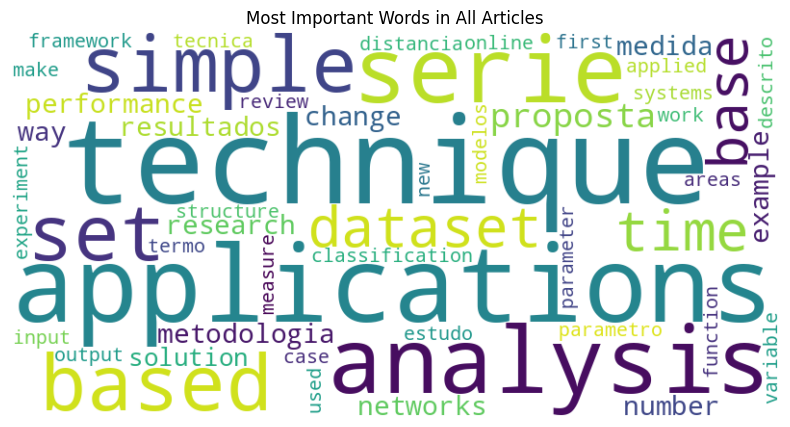

In [37]:
#Plotagem da nuvem de palavras
all_text = ' '.join(docs_df['text'])
processor.plot_wordcloud(all_text)

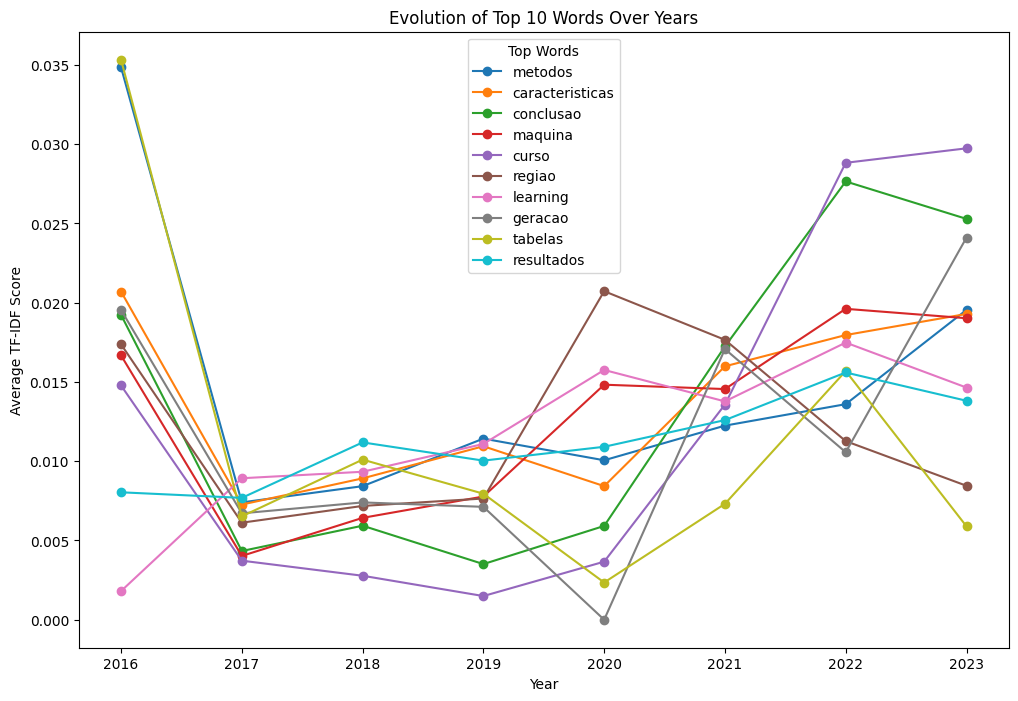

In [38]:
#Plotagem da evolução dos tópicos mais importantes ao longo dos anos com base na matriz TF-IDF
tfidf_matrix, tfidf_features = processor.compute_tfidf(docs_df['text'])
processor.plot_topic_evolution(docs_df, tfidf_features, tfidf_matrix)

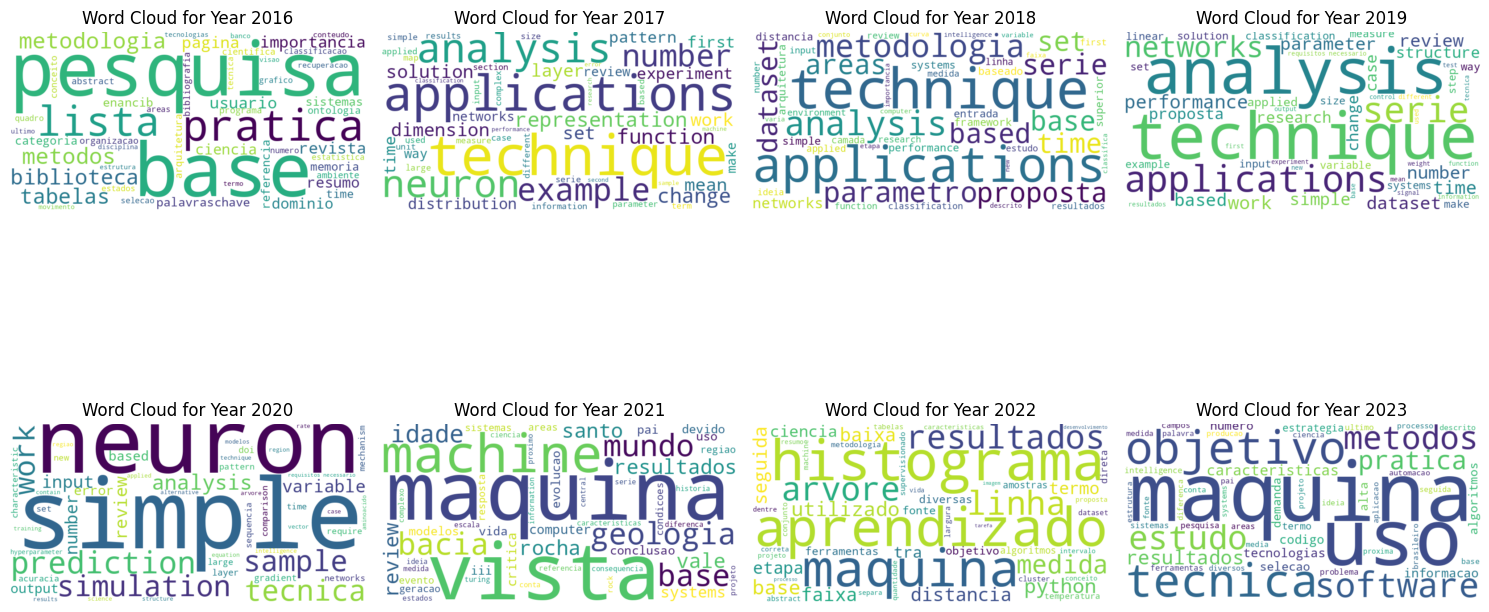

In [39]:
#Plotagens de nuvens de palavras por ano
processor.plot_wordclouds_by_year(docs_df)

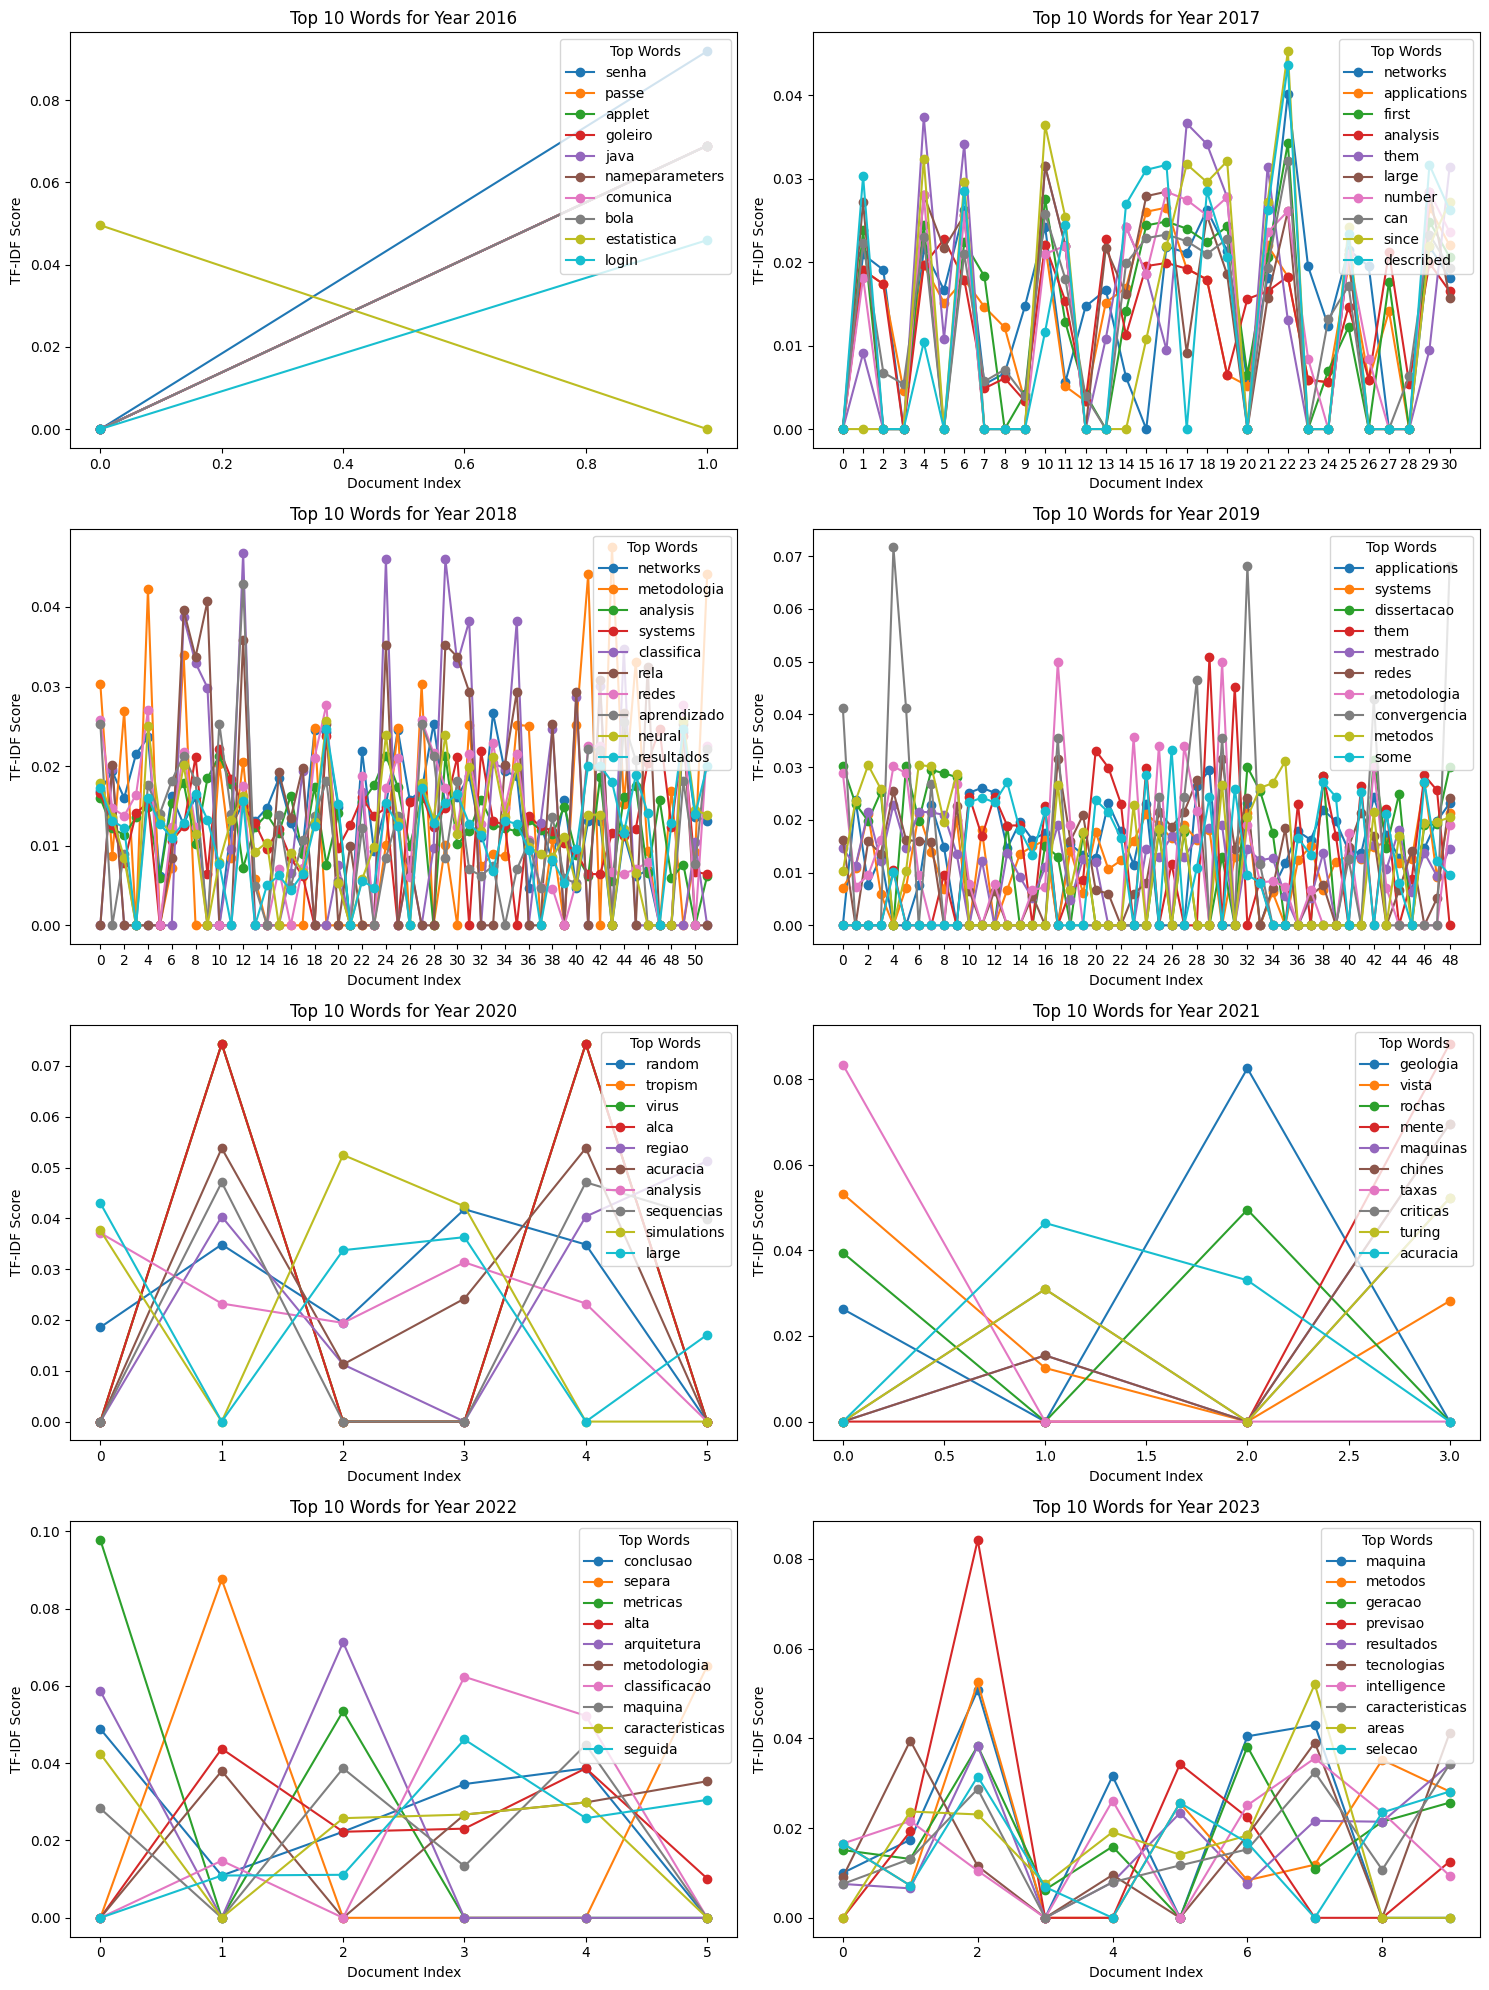

In [40]:
# Plotagens de TF-IDF por ano
processor.plot_tfidf_by_year(docs_df)

# **LDA**

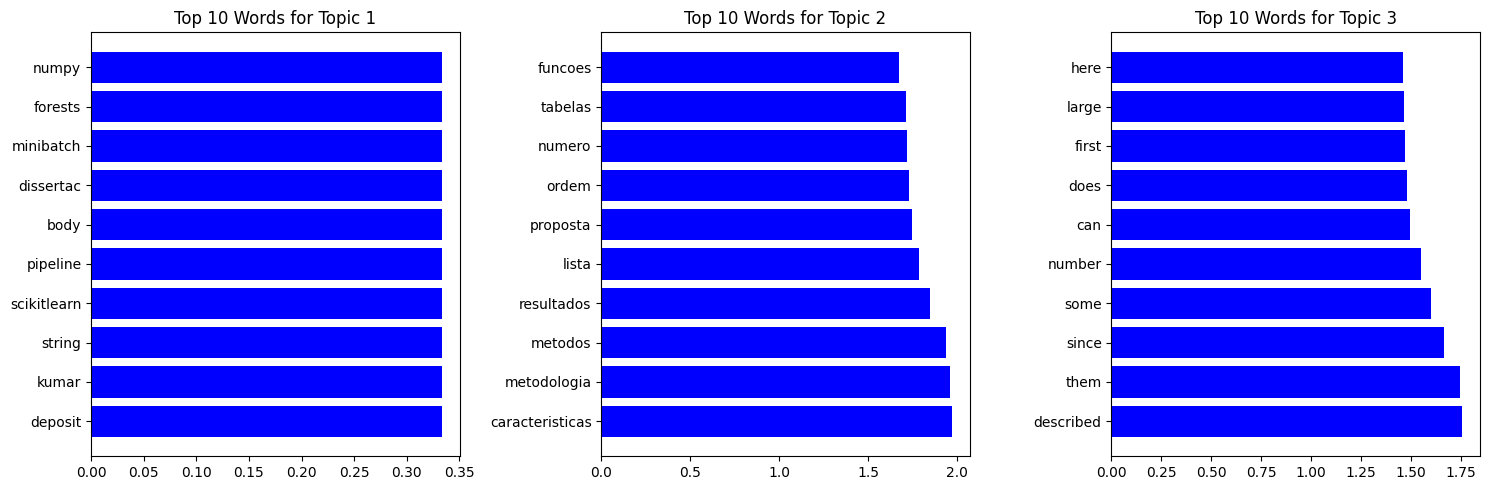

In [41]:
#Treinamento do modelo LDA e plotagem dos tópicos
num_topics = 3
num_words = 10
lda, lda_matrix, feature_names = processor.compute_lda(docs_df['text'], num_topics=num_topics)
processor.plot_top_n_topics(lda, feature_names, num_topics=num_topics, num_words=num_words)

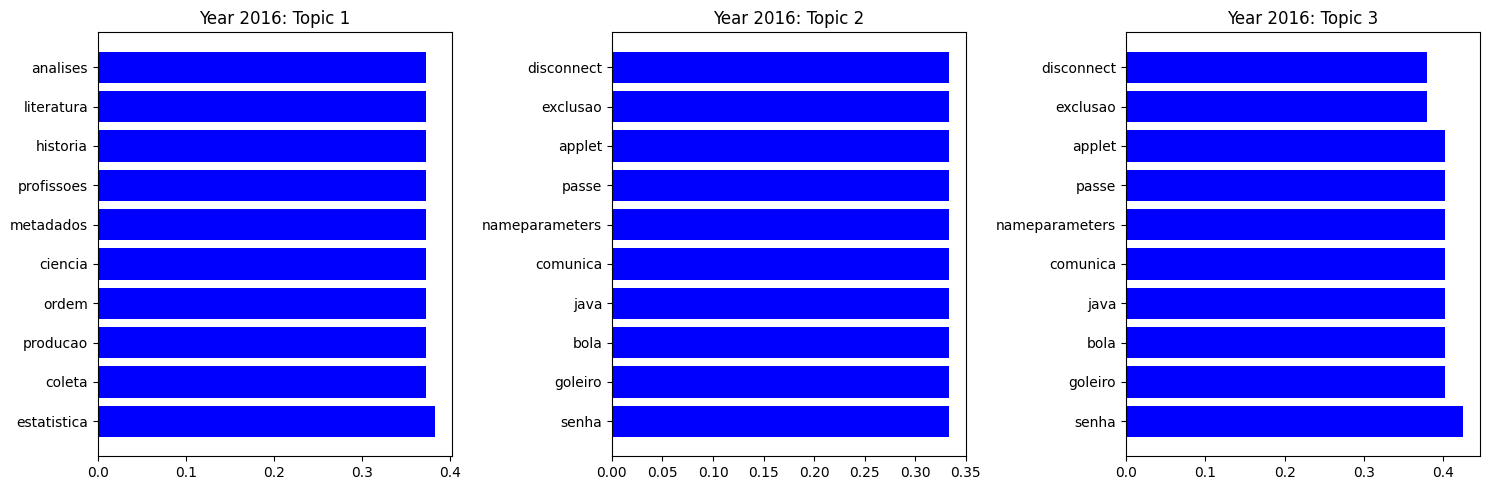

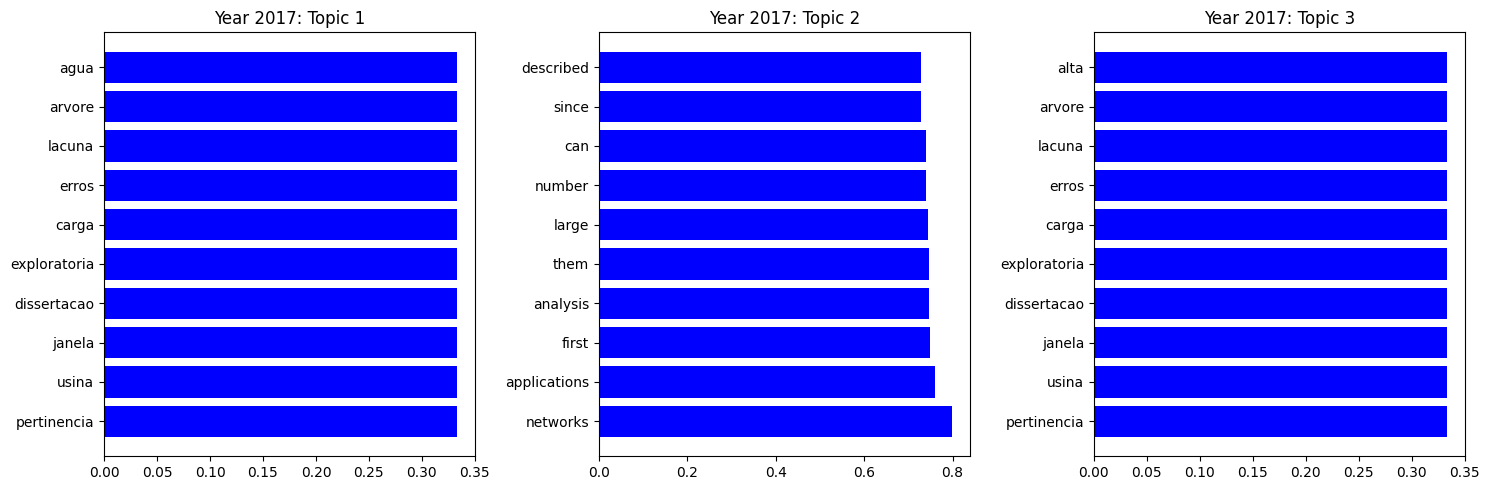

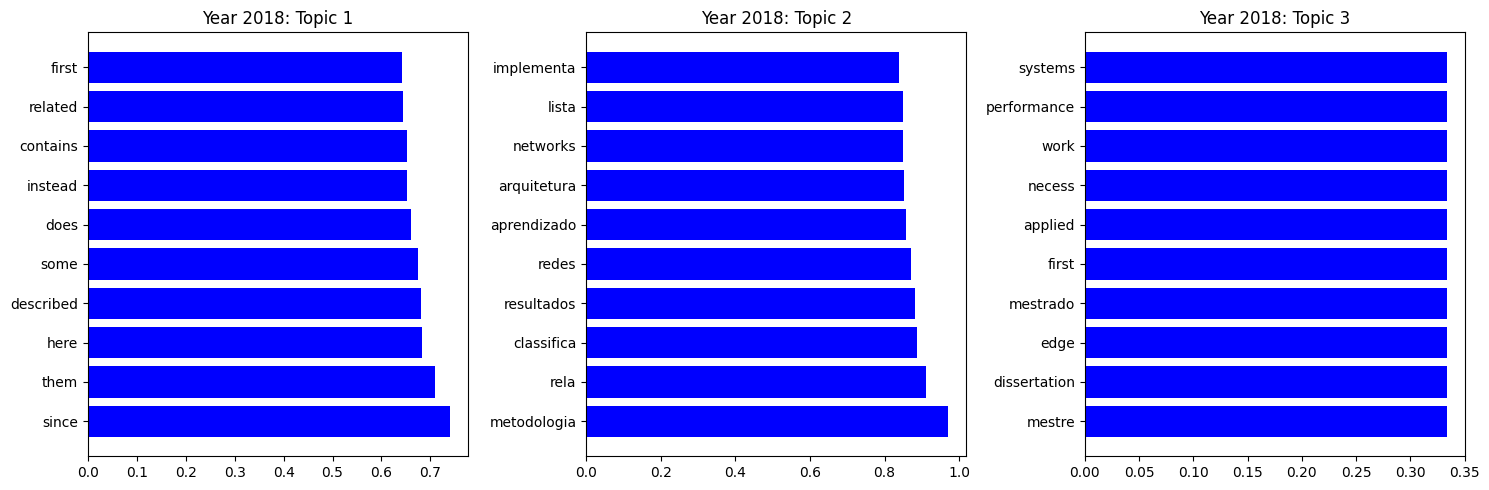

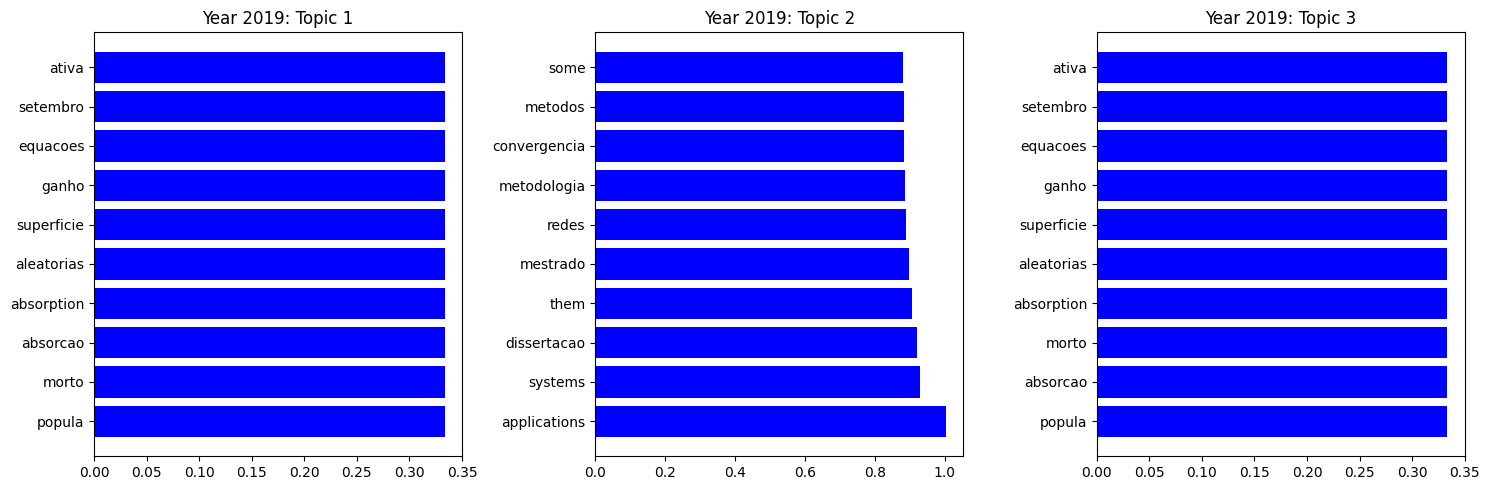

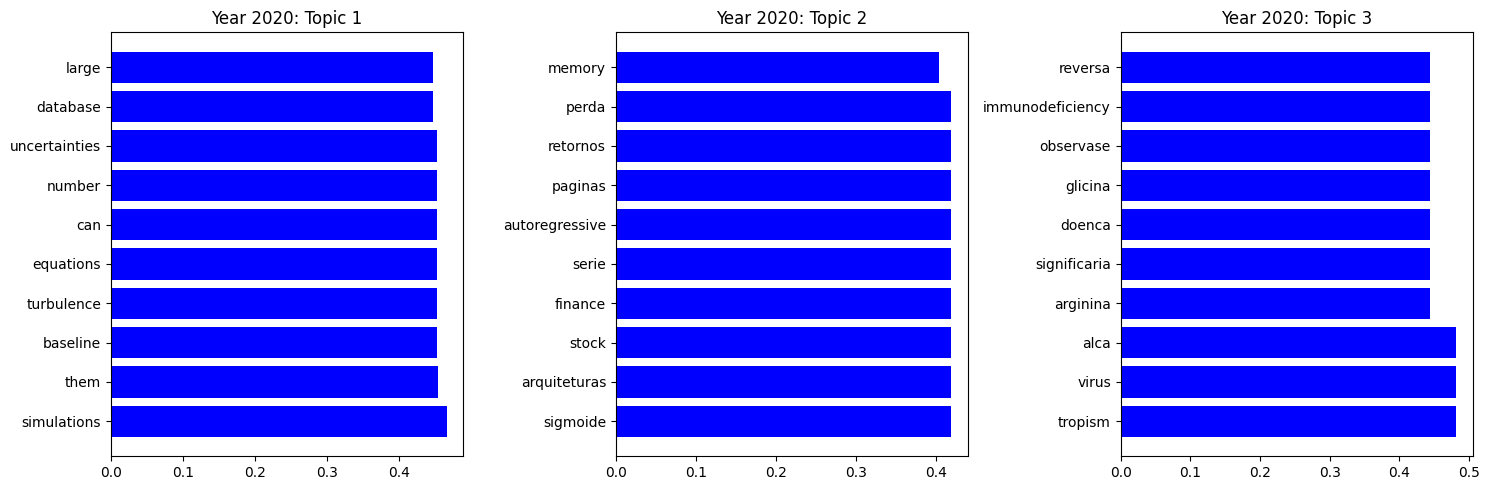

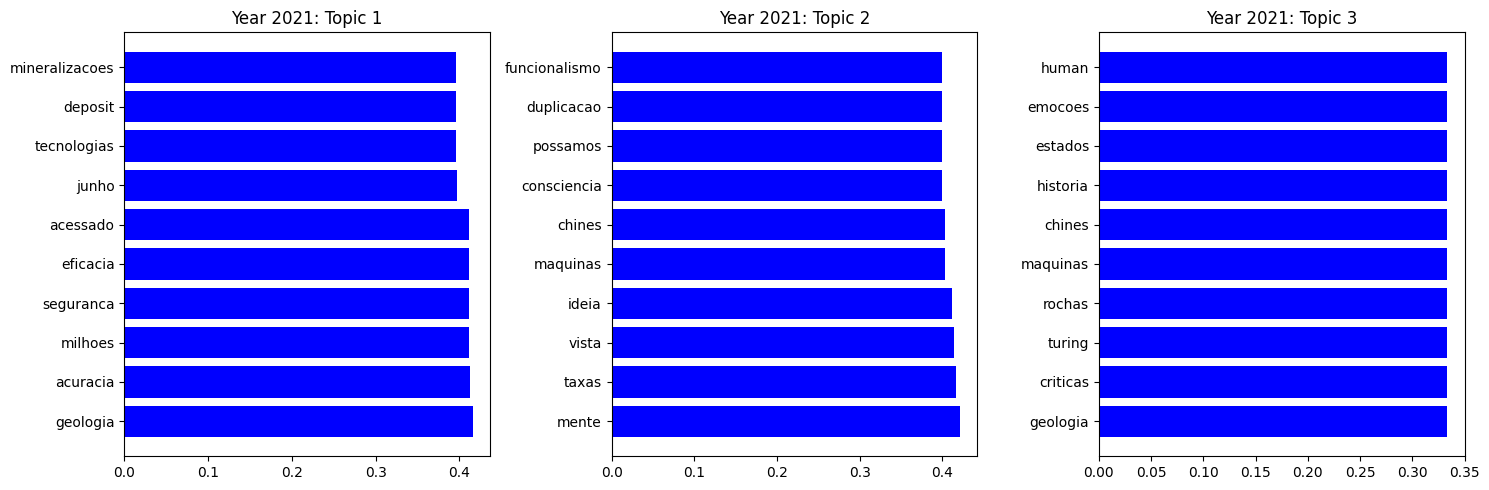

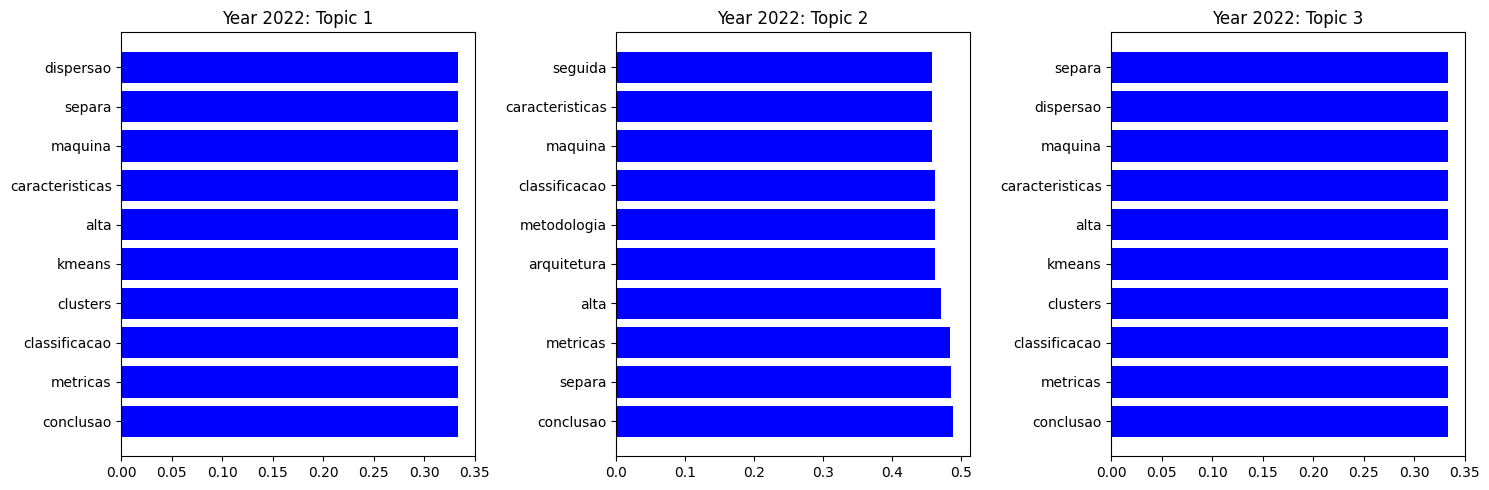

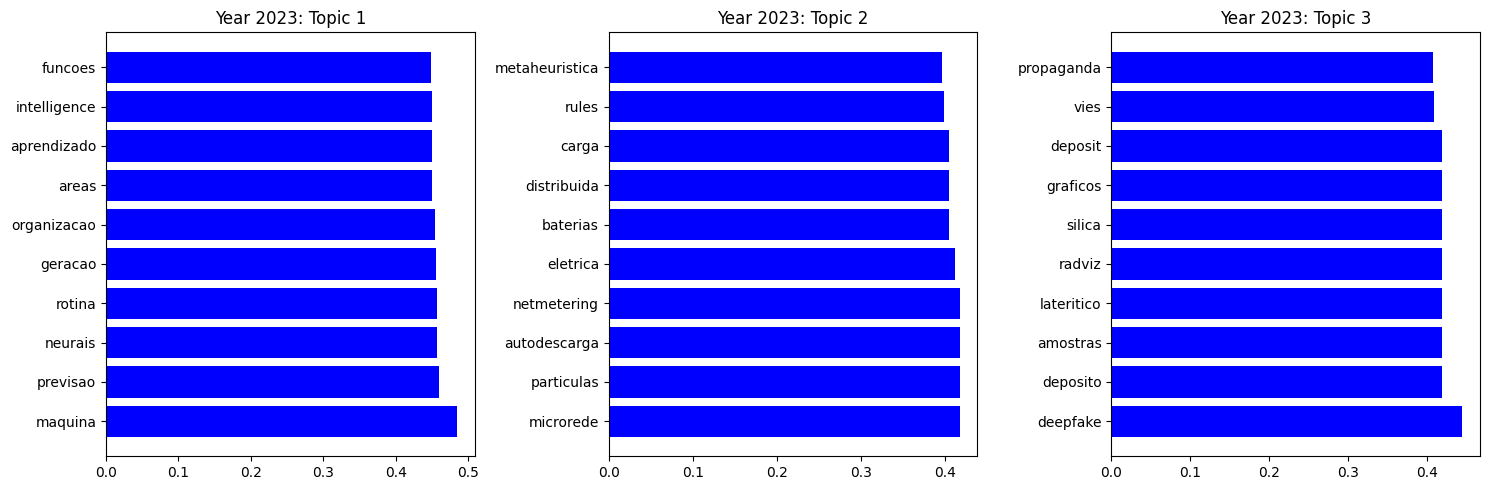

In [42]:
#Plotagem dos tópicos por ano
processor.plot_top_n_topics_by_year(docs_df, num_topics=num_topics, num_words=num_words)
